$H0:$ 기사를 수치화 하면 가계부실선행지수와 유의한 회귀분석할 수 있다  
&nbsp;&nbsp; $y = f(x)$  
&nbsp;&nbsp; $x$ : 월별기사 doc2vec  
&nbsp;&nbsp; $y$ : 가계부실선행지수 1표준편차 초과여부

In [1]:
from konlpy.tag import Okt
okt = Okt()

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
from navsch import *

naver_search : 기사검색 후 결과를 data frame으로 산출  
naver_search_d : 기간별 기사검색 후 결과를 data frame으로 산출

#### 1.기사를 검색한다  
&nbsp;&nbsp;- 2002년 1월~2019년 3월 월별

In [44]:
b_rng = pd.date_range('2002-01-01','2019-04-01',freq='MS').strftime('%Y.%m.%d').tolist()[:-1]
e_rng = pd.date_range('2002-01-01','2019-04-01',freq='M').strftime('%Y.%m.%d').tolist()

In [ ]:
%%time
dfs = []
for beg, end in zip(b_rng,e_rng):
    s = time.time()
    dfs.append(naver_search_d('가계부채',beg,end,pages=1))
    e = time.time() - s
    print('{}~{} done, {} elapsed'.format(beg,end,time.strftime('%H:%M:%S',time.gmtime(e))))
newsdf = pd.concat(dfs,axis=0)    
# Wall time: 1h 12min 22s

In [52]:
newsdf.to_pickle('data/newsdf_03_19.pkl')

In [2]:
import gc

In [3]:
gc.collect()

0

In [4]:
newsdf = pd.read_pickle('data/newsdf_03_19.pkl')

In [6]:
newsdf.shape

(2019, 5)

#### 2.기사를 월별로 합친다

In [6]:
newsdf.head(3)

,ym,qry,date,title,text
0,200201,가계부채,None,"""가계부채 과도한 증가는 `금융불안' 초래""<금융연>",`신용카드 부실이 도화선'(서울=연합뉴스) 한승호기자 = 가계부채의 과도한 증가는 ...
1,200201,가계부채,None,"금융연구원, 31일 가계부채 세미나 개최",머니투데이\n\n[머니투데이] 한국금융연구원(KIF)은 오는 31일 오후 2시 은행...
2,200201,가계부채,None,선진국 가계.기업 모두 빚더미,"= '절약국가 일본' 옛말 가계 부채 세계최고 =\n\n\n\n미국은 물론 영국, ..."


In [7]:
title = newsdf.groupby(['ym','qry'])['title'].apply(lambda x: x.sum())

In [8]:
text = newsdf.groupby(['ym','qry'])['text'].apply(lambda x: x.sum())

In [15]:
ndf = pd.concat([title,text],axis=1).reset_index()

In [16]:
ndf.head()

,ym,qry,title,text
0,200201,가계부채,"""가계부채 과도한 증가는 `금융불안' 초래""<금융연>금융연구원, 31일 가계부채 세...",`신용카드 부실이 도화선'(서울=연합뉴스) 한승호기자 = 가계부채의 과도한 증가는 ...
1,200202,가계부채,"가계부채 335조 ‘사상 최고’…4년만에 배 가까이 증가""가계부채 우려는 과장......",지난해 말 현재 가계부채가 330조원을 넘어 사상 최고를 기록했다.이에따라 가구당 ...
2,200203,가계부채,"가계부채증가 우려할 만한 수준인가?가계부채 위험수위윤 재경차관 ""가계부채 증가속도 ...","1. 송인호 기자, 최근 가계부채증가 속도에 대한 우려의 목소리가 높습니다...외국..."
3,200204,가계부채,"가계부채 GDP의 64% 달해…KDI""과다한 가계부채 주의 필요""<전경련 원로.자문...",가계부문 금융부채가 국내총생산(GDP)에서 차지하는 비중이 지난해 64.8%를 기록...
4,200205,가계부채,"산업은행, 올 경제성장률 6.2%로 상향 전망""한국 월드컵 선전하면 증시 상승""-F...","미경제 둔화, 환율하락 등 경제불안요인 상존(서울=연합뉴스) 한승호기자 = 산업은행..."


In [17]:
ndf.to_pickle('data/ndf.pkl')

In [18]:
del newsdf

#### 3.월별 기사를 tokenize 한다

TaggedDocument에서 tag가 documentID이며  
documentID가 같은 단어들은 비슷하게 벡터라이즈된다  
&nbsp;&nbsp;- 따라서 doc2vec은 tag로 구분되는 모든 기사들을 모아서 한번만 모델링하면 된다 

In [9]:
ndf = pd.read_pickle('data/ndf.pkl')

In [10]:
ndf.head(3)

,ym,qry,title,text
0,200201,가계부채,"""가계부채 과도한 증가는 `금융불안' 초래""<금융연>금융연구원, 31일 가계부채 세...",`신용카드 부실이 도화선'(서울=연합뉴스) 한승호기자 = 가계부채의 과도한 증가는 ...
1,200202,가계부채,"가계부채 335조 ‘사상 최고’…4년만에 배 가까이 증가""가계부채 우려는 과장......",지난해 말 현재 가계부채가 330조원을 넘어 사상 최고를 기록했다.이에따라 가구당 ...
2,200203,가계부채,"가계부채증가 우려할 만한 수준인가?가계부채 위험수위윤 재경차관 ""가계부채 증가속도 ...","1. 송인호 기자, 최근 가계부채증가 속도에 대한 우려의 목소리가 높습니다...외국..."


tok_p: Adjective, Adverb, Noun 인것만 꺼낸다

In [11]:
pos_list = ['Adjective','Adverb','Noun']
tok_p = lambda doc: ['/'.join(t) for t in okt.pos(doc) if t[1] in pos_list] # okt.pos(doc): (사스, Noun), 이거 사스/Noun

In [15]:
s = time.time()
ndf['tok_tit'] = ndf.title.apply(tok_p)
e = time.time()-s
print('title tokenize complete, {} elapsed'.format(time.strftime('%H:%M:%S',time.gmtime(e))))
ndf['tok_txt'] = ndf.text.apply(tok_p)
e = time.time()-s
ndf.to_pickle('data/ndf_tok.pkl')
print('text tokenize complete, {} elapsed'.format(time.strftime('%H:%M:%S',time.gmtime(e))))

title tokenize complete, 00:00:15 elapsed
text tokenize complete, 00:06:07 elapsed


**★불용어로 간주할 품사(조사 등)를 골라내기 위한 탐색작업 -- 시작**

In [12]:
tt = ndf.tok_tit.sum()

In [39]:
m = []
p = []
for t in tt:
    m.append(t.split('/')[0])
    p.append(t.split('/')[1])

In [40]:
mp = pd.DataFrame({'pos':p,'morph':m})

In [41]:
mp.head()

,pos,morph
0,Punctuation,""""
1,Noun,가계부채
2,Noun,과도
3,Josa,한
4,Noun,증가


In [31]:
pos = set([t.split('/')[1] for t in tt])
pos = list(pos)

In [33]:
del pos[1]

In [35]:
del pos[4]

In [36]:
pos

['VerbPrefix',
 'Verb',
 'Josa',
 'Number',
 'URL',
 'Adverb',
 'Punctuation',
 'Modifier',
 'Adjective',
 'Conjunction',
 'Exclamation',
 'Eomi',
 'Determiner',
 'Foreign',
 'Suffix',
 'Noun',
 'Alpha']

In [48]:
mp.columns

Index(['pos', 'morph'], dtype='object')

In [61]:
1!=1

False

In [60]:
mp.groupby('pos').apply(lambda x: x.sample(1))
# Adjective, Adverb, Noun 형용사,부사,명사만 가지고 토크나이즈 한다 ==> 위쪽 코드 중 tok_p 수정 

,,pos,morph
pos,,,
,9082,,
4분,4402,4분,2
Adjective,18872,Adjective,성한
Adverb,6830,Adverb,함께
Alpha,427,Alpha,FT
Conjunction,16478,Conjunction,그리고
Determiner,13942,Determiner,한
Eomi,6604,Eomi,는다
Exclamation,5294,Exclamation,어휴


**☆불용어로 간주할 품사(조사 등)를 골라내기 위한 탐색작업 -- 끝**

#### 4.월별 기사를 doc2vec 한다

In [4]:
ndf = pd.read_pickle('data/ndf_tok.pkl')

In [5]:
ndf.head(1)

,ym,qry,title,text,tok_tit,tok_txt
0,200201,가계부채,"""가계부채 과도한 증가는 `금융불안' 초래""<금융연>금융연구원, 31일 가계부채 세...",`신용카드 부실이 도화선'(서울=연합뉴스) 한승호기자 = 가계부채의 과도한 증가는 ...,"[가계부채/Noun, 과도/Noun, 증가/Noun, 금융/Noun, 불안/Noun...","[신용카드/Noun, 부실/Noun, 도화선/Noun, 서울/Noun, 연합뉴스/N..."


doc2vec용으로 가공(TaggedDocument)  
&nbsp;TaggedDocument에서 tags는 words그룹의 식별자 역할을 한다  
&nbsp;$example:$ TaggedDocuments(words=['had','bankruptcy','year'],tags=['Credit Report'])

token들은 tag(documentID)인 ym으로 구분되므로 모델피팅은 한번만 한다

In [16]:
tagdoc = lambda txt, ym: [TaggedDocument(words=txt,tags=[ym])]

In [17]:
ndf['tag_tit'] = ndf.apply(lambda x: tagdoc(x.tok_tit,x.ym),axis=1)

In [18]:
ndf['tag_txt'] = ndf.apply(lambda x: tagdoc(x.tok_txt,x.ym),axis=1)

In [42]:
tag_tit = [t for x in ndf.tag_tit for t in x] # for를 한번만 써주면 더블 네스티드 리스트가 되어 오류남

doc2vec에 token load

$word2vec$: CBOW ==> $doc2vec$: **DM(Distributed Memory)** dm=1  
$word2vec$: Skip-Gram ==> $doc2vec$: **DBOW(Distributed Bag of Words)** dm=0

#### 4.1 토큰 벡터화 (word embedding)

In [25]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

4

In [26]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [50]:
# doc2vec 인스턴스 생성(dm=0; dbow ~ skip-gram이랑 비슷한거)
max_epochs = 30
vec_size = 10
alpha = 0.025

model_dbow = Doc2Vec(dm=0,
                     vector_size=vec_size,
                     alpha=alpha, 
                     min_alpha=0.00025,
                     min_count=1,
                     workers=cores)

In [51]:
model_dbow.build_vocab(tag_tit)

In [52]:
from sklearn import utils

In [107]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for tt in tqdm(ndf.tag_tit) for x in tt]),
                    total_examples=model_dbow.corpus_count,
                    epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████| 207/207 [00:00<00:00, 207015.00it/s]


Wall time: 869 ms


In [108]:
model_dbow.infer_vector(ndf.tok_tit[0])

array([-2.4025385 ,  1.869682  ,  2.88652   , -1.1291269 ,  1.1922616 ,
        0.73427105, -0.5711016 ,  0.68292105, -1.3383337 , -1.2065998 ],
      dtype=float32)

In [109]:
dvec = list(map(lambda x: model_dbow.infer_vector(x), ndf.tok_tit))
cname = ['dv'+str(i) for i in np.arange(1,vec_size+1)]
dvec = pd.DataFrame(dvec,columns = cname)

In [110]:
ndf_tit_vec = pd.concat([ndf,dvec],axis=1)
ndf_tit_vec.to_pickle('data/ndf_tit_vec.pkl') 
# R에서 reticulate, pd = import('pandas'), df = pd.read_pickle('data/ndf_tit_vec.pkl')=>df는 R data frame됨

In [111]:
%%time
# text(기사본문) 벡터화
tag_txt = [t for x in ndf.tag_txt for t in x]
# 토큰업로드
max_epochs = 30
vec_size = 10
alpha = 0.025

model_dbow_txt = Doc2Vec(dm=0,
                     vector_size=vec_size,
                     alpha=alpha, 
                     min_alpha=0.00025,
                     min_count=1,
                     workers=cores)
model_dbow_txt.build_vocab(tag_txt)
# 모델피팅
for epoch in range(30):
    model_dbow_txt.train(utils.shuffle([x for tt in tqdm(ndf.tag_txt) for x in tt]),
                    total_examples=model_dbow_txt.corpus_count,
                    epochs=10)
    model_dbow_txt.alpha -= 0.002
    model_dbow_txt.min_alpha = model_dbow_txt.alpha
# 벡터라이징
dvec1 = list(map(lambda x: model_dbow.infer_vector(x), ndf.tok_txt))
cname = ['dx'+str(i) for i in np.arange(1,vec_size+1)]
dvec1 = pd.DataFrame(dvec1,columns = cname)
# Wall time: 1min 25s

100%|████████████████████████████████████████████████| 207/207 [00:00<?, ?it/s]


Wall time: 1min 25s


In [112]:
ndf_txt_vec = pd.concat([ndf,dvec1],axis=1)
ndf_txt_vec.to_pickle('data/ndf_txt_vec.pkl') 
# R에서 reticulate, pd = import('pandas'), df = pd.read_pickle('data/ndf_tit_vec.pkl')=>df는 R data frame됨

In [113]:
ndf_txt_vec.head(1)

,ym,qry,title,text,tok_tit,tok_txt,tag_tit,tag_txt,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10
0,200201,가계부채,"""가계부채 과도한 증가는 `금융불안' 초래""<금융연>금융연구원, 31일 가계부채 세...",`신용카드 부실이 도화선'(서울=연합뉴스) 한승호기자 = 가계부채의 과도한 증가는 ...,"[가계부채/Noun, 과도/Noun, 증가/Noun, 금융/Noun, 불안/Noun...","[신용카드/Noun, 부실/Noun, 도화선/Noun, 서울/Noun, 연합뉴스/N...","[([가계부채/Noun, 과도/Noun, 증가/Noun, 금융/Noun, 불안/No...","[([신용카드/Noun, 부실/Noun, 도화선/Noun, 서울/Noun, 연합뉴스...",2.395438,-1.922362,-2.885324,1.168038,-1.166602,-0.759743,0.640993,-0.718837,1.314534,1.184489


In [114]:
ndf_tit_vec.head(1)

,ym,qry,title,text,tok_tit,tok_txt,tag_tit,tag_txt,dv1,dv2,dv3,dv4,dv5,dv6,dv7,dv8,dv9,dv10
0,200201,가계부채,"""가계부채 과도한 증가는 `금융불안' 초래""<금융연>금융연구원, 31일 가계부채 세...",`신용카드 부실이 도화선'(서울=연합뉴스) 한승호기자 = 가계부채의 과도한 증가는 ...,"[가계부채/Noun, 과도/Noun, 증가/Noun, 금융/Noun, 불안/Noun...","[신용카드/Noun, 부실/Noun, 도화선/Noun, 서울/Noun, 연합뉴스/N...","[([가계부채/Noun, 과도/Noun, 증가/Noun, 금융/Noun, 불안/No...","[([신용카드/Noun, 부실/Noun, 도화선/Noun, 서울/Noun, 연합뉴스...",-2.40795,1.875965,2.892519,-1.133063,1.196998,0.741866,-0.567771,0.68658,-1.33762,-1.208902


In [135]:
bsi = pd.read_pickle('data/busil_idx.pkl')

In [137]:
bsi.ym = bsi.ym.astype(str)
bsi.set_index('ym',inplace=True)

In [138]:
bsi.head(1)

,cycle,tcycle,가계소득지표,가계소비지표,차입수준지표
ym,,,,,
201207,104.4,103.2,0.109,0.448,0.321


In [139]:
a = ndf_tit_vec.set_index('ym')
ndf_tit_vec1 = a.merge(bsi,how='left',left_index=True,right_index=True)

In [140]:
a = ndf_txt_vec.set_index('ym')
ndf_txt_vec1 = a.merge(bsi,how='left',left_index=True,right_index=True)

In [141]:
ndf_tit_vec1.to_pickle('data/ndf_tit_vec1.pkl')
ndf_txt_vec1.to_pickle('data/ndf_txt_vec1.pkl')

#### 가계부실선행지수

In [127]:
busil_idx = pd.read_clipboard(sep='\t')

In [130]:
busil_idx.head()

,ym,cycle,tcycle,가계소득지표,가계소비지표,차입수준지표
0,201207,104.4,103.2,0.109,0.448,0.321
1,201208,104.4,103.2,0.121,0.387,0.367
2,201209,104.4,103.2,0.137,0.327,0.407
3,201210,104.3,103.1,0.157,0.262,0.441
4,201211,104.2,103.0,0.175,0.200,0.467


In [131]:
busil_idx.to_pickle('data/busil_idx.pkl')

In [132]:
bs = busil_idx.copy()

In [133]:
bs['date'] = pd.to_datetime(bs.ym, format='%Y%m')

In [134]:
bs.head()

,ym,cycle,tcycle,가계소득지표,가계소비지표,차입수준지표,date
0,201207,104.4,103.2,0.109,0.448,0.321,2012-07-01
1,201208,104.4,103.2,0.121,0.387,0.367,2012-08-01
2,201209,104.4,103.2,0.137,0.327,0.407,2012-09-01
3,201210,104.3,103.1,0.157,0.262,0.441,2012-10-01
4,201211,104.2,103.0,0.175,0.200,0.467,2012-11-01


In [137]:
import matplotlib.pyplot as plt

In [147]:
plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
plt.

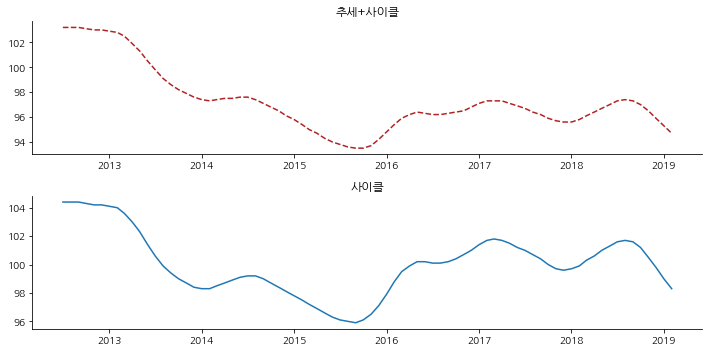

In [156]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot_date('date','tcycle',fmt='--',data=bs,color='firebrick')
plt.title('추세+사이클')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplot(212)
plt.plot_date('date','cycle',fmt='-',data=bs)
plt.title('사이클')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

사이클 또는 추세+사이클이 얼마 이상일 때 tag를 1로 줘서 모델링 해보자

#### 5.월별기사와 가계부실선행지수를 합친다